# Common Part

In [1]:
# Finding spark path for no error imports
import findspark
findspark.init()

In [2]:
# import section
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.mllib.recommendation import ALS
from pyspark.mllib.recommendation import Rating
import numpy as np
import random  

In [3]:
# initializing spark app and contex
conf = SparkConf().setAppName("151805011_151805024_RECSYS")
sc = SparkContext(conf=conf)

In [8]:
# loading all book rating data for recommendation and data visualization
allRatings = sc.textFile("book_ratings.dat")

In [7]:
books_info = sc.textFile("books_info.dat")

In [1]:
import socket
hostname = socket.gethostname()
hostip = socket.gethostbyname(hostname)
print(hostname,"-->",hostip)

DESKTOP-2C2TS6E --> 172.17.44.209


# Which ten book most rated?

In [9]:
books_info.take(5)

["1\t0060973129\tDecision in Normandy\tCarlo D'Este\t1991\tHarperPerennial\thttp://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg\thttp://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg\thttp://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg\t",
 '2\t0393045218\tThe Mummies of Urumchi\tE. J. W. Barber\t1999\tW. W. Norton &amp\t Company\thttp://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg\thttp://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg\thttp://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg\t',
 "3\t0425176428\tWhat If?: The World's Foremost Military Historians Imagine What Might Have Been\tRobert Cowley\t2000\tBerkley Publishing Group\thttp://images.amazon.com/images/P/0425176428.01.THUMBZZZ.jpg\thttp://images.amazon.com/images/P/0425176428.01.MZZZZZZZ.jpg\thttp://images.amazon.com/images/P/0425176428.01.LZZZZZZZ.jpg\t",
 '4\t0452264464\tBeloved (Plume Contemporary Fiction)\tToni Morrison\t1994\tPlume\thttp://images.amazon.com/images/P/04

In [10]:
proper_book_infos = books_info.map(lambda line: line.split("\t")).map(lambda l:( (int(l[0])), l[2]))

In [11]:
proper_book_infos.take(5)

[(1, 'Decision in Normandy'),
 (2, 'The Mummies of Urumchi'),
 (3,
  "What If?: The World's Foremost Military Historians Imagine What Might Have Been"),
 (4, 'Beloved (Plume Contemporary Fiction)'),
 (5,
  "Our Dumb Century: The Onion Presents 100 Years of Headlines from America's Finest News Source")]

In [12]:
# counting most rated book 
books = allRatings.map(lambda line: line.split("\t")).map(lambda l: (int(l[1])))
bookCounts = books.map(lambda book: (book, 1)).reduceByKey(lambda a,b:a+b)

In [13]:
bookCounts.take(5)

[(6264, 4), (4350, 23), (6252, 7), (202, 76), (6266, 5)]

In [14]:
join_book_name = bookCounts.join(proper_book_infos)

In [15]:
join_book_name.take(5)

[(6264, (4, 'Something Wicked This Way Comes')),
 (6252, (7, 'Sacred Sins')),
 (160, (5, 'The Subtle Knife (His Dark Materials, Book 2)')),
 (6244, (1, 'Bitter Sweet')),
 (6260, (3, 'Wilderness Tips'))]

In [16]:
sorted_ratings = join_book_name.map(lambda l: (l[1])).sortBy(lambda l: -l[0])

In [17]:
sorted_ratings.take(10)

[(160, 'Impossible Vacation'),
 (119, 'The Rescue'),
 (89, "Tycoon'S Temptation (Silhouette Desire, No. 1414)"),
 (88,
  'Past Lives, Present Dreams: How to Use Reincarnation for Personal Growth'),
 (86, 'The Queen of the Damned (Vampire Chronicles (Paperback))'),
 (79, 'The Right Hand of Amon'),
 (77, "She's Come Undone (Oprah's Book Club (Paperback))"),
 (76, 'What a Wonderful World: A Lifetime of Recordings'),
 (75, 'The Deal'),
 (73, 'Seabiscuit: An American Legend')]

In [18]:
mLabels =  sorted_ratings.map(lambda l: (l[1])).collect()
mRatings = sorted_ratings.map(lambda l:(int(l[0]))).collect()

In [19]:
mLabels[:10]

['Impossible Vacation',
 'The Rescue',
 "Tycoon'S Temptation (Silhouette Desire, No. 1414)",
 'Past Lives, Present Dreams: How to Use Reincarnation for Personal Growth',
 'The Queen of the Damned (Vampire Chronicles (Paperback))',
 'The Right Hand of Amon',
 "She's Come Undone (Oprah's Book Club (Paperback))",
 'What a Wonderful World: A Lifetime of Recordings',
 'The Deal',
 'Seabiscuit: An American Legend']

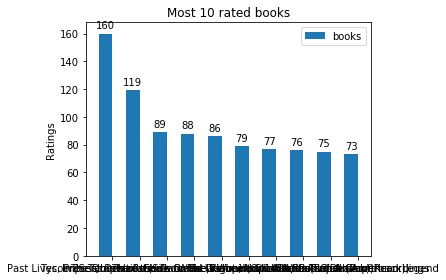

In [20]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = mLabels[:10]
ratings = mRatings[:10]


x = np.arange(len(labels))  # the label locations
width = .50  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, ratings, width, label='books')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Ratings')
ax.set_title('Most 10 rated books')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
fig.tight_layout()

plt.show()

# ALS Recommendation system part

In [21]:
# splitting the data 70% for training and 30% for testing
(trainRatings, testRatings) = allRatings.randomSplit([0.7, 0.3])

In [22]:
# checking splitted train data
trainRatings.take(5)

['1\t6264\t7.000000',
 '1\t6252\t5.000000',
 '1\t4810\t5.000000',
 '1\t6251\t9.000000',
 '1\t160\t9.000000']

In [23]:
# checking splitted test data
testRatings.take(5)

['1\t4350\t7.000000',
 '1\t202\t9.000000',
 '1\t6266\t6.000000',
 '1\t631\t10.000000',
 '1\t6244\t7.000000']

In [24]:
# creating Rating objects from transforming by splitted data into fields
train_data = trainRatings.map(lambda l: l.split("\t")).map(lambda l: Rating(int(l[0]), int(l[1]), float(l[2])))

In [25]:
# checking transformed train data, looking for Rating objects
train_data.take(5)

[Rating(user=1, product=6264, rating=7.0),
 Rating(user=1, product=6252, rating=5.0),
 Rating(user=1, product=4810, rating=5.0),
 Rating(user=1, product=6251, rating=9.0),
 Rating(user=1, product=160, rating=9.0)]

In [26]:
# for model prediction eliminating test datas given ratings(labels)
test_data = testRatings.map(lambda l: l.split("\t")).map(lambda l: (int(l[0]), int(l[1])))

In [27]:
# transformation checking
test_data.take(5)

[(1, 4350), (1, 202), (1, 6266), (1, 631), (1, 6244)]

In [28]:
arr_mse = []

In [29]:
for rank in ([4, 6, 10]):
    for numIterations in ([4, 6, 10]):
        for _lambda in ([0.1, 0.01]):
            
            # seed for randomization (preventing overfitting, memorization)
            random.seed(5011) # random.seed(5024)
            
            # creating ALS model instance with training it
            model = ALS.train(train_data, rank, numIterations, lambda_=_lambda, nonnegative=True)

            # predicting all of test data
            predictions = model.predictAll(test_data)

            # transforming prediction's Rating objects to custom schema for join operation to mse calculation
            predicted_test_ratings = predictions.map(lambda l: (  (l[0],l[1]), float(l[2])  ))

            # transforming original test datas labels for join operation
            org_test_ratings = testRatings.map(lambda l: l.split("\t")).map(lambda l: ((int(l[0]),int(l[1])),float(l[2])   )  )

            # joining prediction and original test ratings for proper mse calculation
            join_rdd = predicted_test_ratings.join(org_test_ratings)

            # getting predicted and original rating tupple
            org_test_ratings = join_rdd.map(lambda l: (l[1]))

            # seperating predicted and original rating tupple
            org_ratings = org_test_ratings.map(lambda l: l[1])
            pred_ratings = org_test_ratings.map(lambda l: l[0])

            # turning type rdd to list for mse calculation
            arr_org_ratings = org_ratings.collect()
            arr_pred_ratings = pred_ratings.collect()

            # mse calculation in one line with numpy library
            mse = np.square(np.subtract(arr_org_ratings, arr_pred_ratings)).mean()
            arr_mse.append(mse)

In [30]:
arr_mse

[4.690589116274951,
 13.944573019644775,
 4.564894039006604,
 10.621736997474885,
 4.650766282792199,
 8.044538924258708,
 5.099880873423481,
 17.38131301716288,
 5.219832833608394,
 10.081407311940957,
 4.988577417314946,
 9.663132430812722,
 5.807769611172119,
 11.190920297227008,
 5.523034284275562,
 9.711939467034377,
 5.3857356612295915,
 10.155115830771914]